In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pnd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import KFold
from itertools import product
from collections import Counter
import itertools
import inspect
from GeneticOptimization import GeneticOptimization
from sklearn.linear_model import LinearRegression

In [2]:
arr = np.genfromtxt('data/prices.csv', delimiter=',')
xs, ys = arr[:,:2].copy()[1:], arr[:, 2:].ravel()[1:]
print("Dataset size: ", len(xs))

Dataset size:  47


<IPython.core.display.Javascript object>


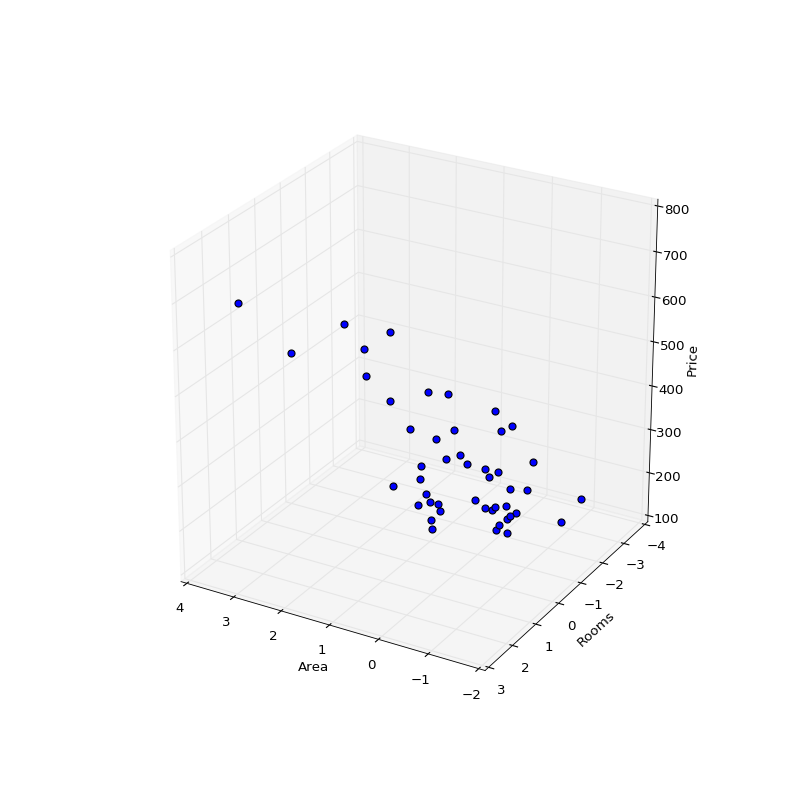

In [3]:


def show(xs, ys, elev=25.0, azim=120):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.scatter(xs[:, 0], xs[:, 1], ys, s=40, zdir='z', depthshade=False)
    
    ax.set_xlabel('Area')
    ax.set_ylabel('Rooms')
    ax.set_zlabel('Price')
    
    ax.view_init(elev=elev, azim=azim)
    #‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
    
    plt.show()
x_scaled = StandardScaler().fit_transform(xs)
y_scaled = ys/1000
show(x_scaled, y_scaled)

In [278]:
class LinearRegressor:
    def __init__(self, dim, kernel=None, scaler=None):
        if kernel is None:
            kernel = lambda x: np.hstack((1,x))
        self.scaler = scaler
        self.kernel = kernel
        self.dim = dim
        t = kernel(np.random.uniform(0, 1, dim))
        if t[0] != 1:
            print('Warning: kernel(np.random.uniform(0, 1, dim))[0] != 1')
        self.w = np.zeros(len(t))
    
    def _sgd(self, X, Y, reg=1., lr=0.1, eps=1e-9, maxiter=1000):
        self.w = np.zeros(X.shape[1])
        m = len(X)
        last_obj= -np.inf
        t = lr
        lr = 1.
        for it in range(maxiter):
            for x, y in zip(X, Y):
                self.w = (1 - lr*reg/m) * self.w - lr * (np.inner(self.w, x) - y) * x / m
            cur_obj = ((np.dot(X, self.w) - Y)**2).mean()/2 + (self.w**2).sum() * reg/(2*m)
            if abs(last_obj - cur_obj) < eps:
                break
            last_obj = cur_obj
            lr = lr*(1+lr*t*it)**-1
        return self.w
    
    def _analytics(self, X, Y, reg=1.):
        tmp = np.dot(X.transpose(), X)
        tmp += np.eye(tmp.shape[0]) * reg     
        tmp = np.linalg.inv(tmp)
        self.w = np.dot(Y, np.dot(X, tmp))
        return self.w
    
    def fit(self, X, y, reg=1., solver='sgd', **params):
        if self.scaler is not None:
            self.scaler = self.scaler.fit(X)
            X = self.scaler.transform(X)
        X = np.apply_along_axis(self.kernel, 1, X)
        if solver == 'sgd':
            self._sgd(X, y, reg, **params)  
        elif solver == 'analytics':
            self._analytics(X, y, reg, **params)
        return self
        
    def predict(self, x):
        if self.scaler is not None:
            x = self.scaler.transform(x.reshape(1, -1)).ravel()
        x = self.kernel(x)
        return np.inner(self.w, x)

In [279]:
def kf_cross_validation(regressor, xs, ys, n_fold=10, times=1, **params):
    measure = lambda x, y: ((x-y)**2).mean()
    res = 0
    for _ in range(times):
        kf = KFold(len(xs), n_fold, True, 0)
        kf_sum = 0
        for train_i, test_i in kf:
            regressor = regressor.fit(xs[train_i], ys[train_i], **params)
            predicted = np.apply_along_axis(regressor.predict, 1, xs[test_i])
            kf_sum += measure(predicted, ys[test_i])
        res += kf_sum/n_fold
    return res/times

In [282]:
regressor = LinearRegressor(2, scaler=StandardScaler())
print(kf_cross_validation(regressor, xs, ys, n_fold=7, times=1, solver='sgd', lr=0.0001, reg=0))
print(kf_cross_validation(regressor, xs, ys, n_fold=7, times=1, solver='analytics', reg=0))

4755493983.62
4753869366.15


In [232]:
def mse(predicted, label):
    return ((predicted - label) ** 2).mean()

In [28]:
xs_scaled = MinMaxScaler().fit_transform(xs)
ys_scaled = MinMaxScaler().fit_transform(ys)
xs_appended = np.apply_along_axis(lambda x: np.append(x, 1), 1, xs_scaled)

minimize_f = lambda X, Y: lambda w: mse(np.apply_along_axis(lambda x: np.dot(w, x), 1, X), Y)
ga = GeneticOptimization()
kf_cross_validation(xs_appended, ys_scaled, ga.fit, minimize_f, n_fold=2)

/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


0.01479641379987932